In [ ]:
pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
# https://github.com/rawpython/remi

In [ ]:
!rm -rf remi   # delete any old copies

!git clone https://github.com/rawpython/remi
%cd remi

!pip install GitPython pandas

import os
import git
import pandas as pd

repo_path = os.getcwd()
repo = git.Repo(repo_path)   # now valid repo

Cloning into 'remi'...
remote: Enumerating objects: 6818, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 6818 (delta 48), reused 40 (delta 40), pack-reused 6718 (from 2)
Receiving objects: 100% (6818/6818), 4.36 MiB | 12.60 MiB/s, done.
Resolving deltas: 100% (4679/4679), done.
/content/remi


In [ ]:
def is_bug_fix_commit(message):
    """
    Define bug-fix commits heuristically:
    Commit messages containing keywords like 'fix', 'bug', 'issue', 'error'
    """
    keywords = ['fixed', 'bug', 'fixes', 'fix', 'crash', 'solves',
                'resolves', 'issue', 'regression', 'fall back',
                'assertion', 'converity', 'reproducible', 'stack-wanted',
                'steps-wanted', 'testcase', 'failur', 'fail', 'npe',
                'except', 'broken', 'differential testing', 'error',
                'hang', 'test fix', 'steps to reproduce', 'crash',
                'assertion', 'failure', 'leak', 'stack trace', 'heap overflow',
                'freez', 'problem', 'overflow', 'avoid', 'workaround', 'break', 'stop']
    msg_lower = message.lower()
    return any(kw in msg_lower for kw in keywords)

bug_fix_commits = []
for commit in repo.iter_commits("master"):  # branch = main
    if is_bug_fix_commit(commit.message):
        bug_fix_commits.append({
            "hash": commit.hexsha,
            "message": commit.message.strip(),
            "parent_hashes": [p.hexsha for p in commit.parents],
            "is_merge": len(commit.parents) > 1,
            "modified_files": [diff.a_path if diff.a_path else diff.b_path
                               for diff in commit.diff(commit.parents[0])
                               ] if commit.parents else []
        })

# Save to CSV
bugfix_df = pd.DataFrame(bug_fix_commits)
bugfix_df.to_csv("/content/bug_fix_commits.csv", index=False)
print("Saved bug_fix_commits.csv")

file_diffs = []
for commit_data in bug_fix_commits:
    commit = repo.commit(commit_data["hash"])
    if not commit.parents:  # skip root commit
        continue

    parent = commit.parents[0]
    diffs = commit.diff(parent, create_patch=True)

    for diff in diffs:
        try:
            file_name = diff.b_path if diff.b_path else diff.a_path
            before_code = ""
            current_code = ""
            if diff.a_blob:
                before_code = diff.a_blob.data_stream.read().decode("utf-8", errors="ignore")
            if diff.b_blob:
                current_code = diff.b_blob.data_stream.read().decode("utf-8", errors="ignore")

            file_diffs.append({
                "hash": commit.hexsha,
                "message": commit.message.strip(),
                "filename": file_name,
                "source_before": before_code,
                "source_current": current_code,
                "diff": diff.diff.decode("utf-8", errors="ignore"),
                "LLM_inference": "",   # Placeholder for fix type classification
                "rectified_message": "" # Placeholder for auto-refined commit msg
            })
        except Exception as e:
            print(f"Error processing diff for {commit.hexsha}: {e}")

# Save to CSV
filediff_df = pd.DataFrame(file_diffs)
filediff_df.to_csv("/content/file_level_diffs.csv", index=False)
print("Saved file_level_diffs.csv")

Saved bug_fix_commits.csv
Saved file_level_diffs.csv


In [ ]:
df = pd.read_csv("/content/bug_fix_commits.csv")

# Check first few rows
print(df.head())

                                       hash  \
0  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
1  c6a61daf929ded2400e82082805817ad51539eab   
2  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   
3  005d6b0183a695388c2d57f77c2c2d8837eab3e1   
4  e591bef9bc67238730db9fe6457381dc12baff64   

                                     message  \
0  FileUploader.onprogress event. Issue #534   
1     Fixed classname in editor subclassing.   
2               BugFix Link now works again.   
3                   Process example changes.   
4                   Process example changes.   

                                  parent_hashes  is_merge  \
0  ['4be71eb0ab15ade4a6e327a74ad329838e8ec022']     False   
1  ['e2d6107d6d29a2c60a97b46f25429ac6f124ab3b']     False   
2  ['3d320de6665ea4a679a1e916f337b300d500b765']     False   
3  ['e591bef9bc67238730db9fe6457381dc12baff64']     False   
4  ['d9cd7801c4ba2cd11fde848db3ed8f1b055ddb50']     False   

                                    modified_files  
0  ['exa

In [ ]:
df = pd.read_csv("/content/file_level_diffs.csv")
print(df.head())

                                       hash  \
0  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
1  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
2  c6a61daf929ded2400e82082805817ad51539eab   
3  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   
4  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   

                                     message                      filename  \
0  FileUploader.onprogress event. Issue #534  examples/progress_bar_app.py   
1  FileUploader.onprogress event. Issue #534                   remi/gui.py   
2     Fixed classname in editor subclassing.              editor/editor.py   
3               BugFix Link now works again.           editor/FBD_model.py   
4               BugFix Link now works again.            editor/FBD_view.py   

                                       source_before  \
0  """\n   Licensed under the Apache License, Ver...   
1  """\n   Licensed under the Apache License, Ver...   
2  """\n   Licensed under the Apache License, Ver...   
3  import inspect\n\ncla

In [ ]:
!pip install --quiet transformers sentencepiece
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from tqdm import tqdm
MODEL_NAME = "mamiksik/CommitPredictorT5"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
print("CommitPredictorT5 loaded")
df = pd.read_csv("/content/file_level_diffs.csv")
print("Loaded diffs:", df.shape)
def predict_fix_type(diff, original_msg, max_length=32):
    """
    Use CommitPredictorT5 to predict only the fix type (short label).
    Input is truncated to keep speed/memory low.
    """
    input_text = f"classify type | diff: {diff[:300]} message: {original_msg}"  # shorter input

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    outputs = model.generate(**inputs, max_length=max_length, num_beams=2)  # fewer beams = faster
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction.strip()
fix_types = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    diff = row["diff"] if isinstance(row["diff"], str) else ""
    message = row["message"] if isinstance(row["message"], str) else ""
    try:
        prediction = predict_fix_type(diff, message)
        fix_types.append(prediction)
    except Exception as e:
        fix_types.append(f"error: {e}")
df["LLM_inference_fix_type"] = fix_types
df[["hash", "message", "filename", "diff", "LLM_inference_fix_type"]].to_csv(
    "/content/file_level_diffs_fix_types.csv", index=False
)
print("Saved file_level_diffs_fix_types.csv (only fix type)")

CommitPredictorT5 loaded
Loaded diffs: (797, 8)


100%|██████████| 797/797 [23:25<00:00,  1.76s/it]

Saved file_level_diffs_fix_types.csv (only fix type)


In [ ]:
df = pd.read_csv("/content/file_level_diffs_fix_types.csv")

# Check first few rows
print(df.head())

                                       hash  \
0  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
1  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
2  c6a61daf929ded2400e82082805817ad51539eab   
3  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   
4  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   

                                     message                      filename  \
0  FileUploader.onprogress event. Issue #534  examples/progress_bar_app.py   
1  FileUploader.onprogress event. Issue #534                   remi/gui.py   
2     Fixed classname in editor subclassing.              editor/editor.py   
3               BugFix Link now works again.           editor/FBD_model.py   
4               BugFix Link now works again.            editor/FBD_view.py   

                                                diff  \
0  @@ -1,50 +0,0 @@\n-"""\n-   Licensed under the...   
1  @@ -1582,18 +1582,6 @@ class HEAD(Tag):\n     ...   
2  @@ -444,7 +444,7 @@ class Project(gui.Containe...   
3  @@ -85,10 +85,13 @@ c

In [ ]:
df = pd.read_csv("/content/file_level_diffs_fix_types.csv")
def predict_rectified_message(diff, original_msg, max_length=64):
    """
    Use CommitPredictorT5 to generate a rectified commit message.
    Input: file diff + original message.
    Output: improved/rectified commit message.
    """
    input_text = f"rectify message | diff: {diff[:400]} message: {original_msg}"

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    outputs = model.generate(**inputs, max_length=max_length, num_beams=4)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return prediction.strip()


rectified_messages = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    diff = row["diff"] if isinstance(row["diff"], str) else ""
    message = row["message"] if isinstance(row["message"], str) else ""

    try:
        prediction = predict_rectified_message(diff, message)
        rectified_messages.append(prediction)
    except Exception as e:
        rectified_messages.append(f"error: {e}")

# Add the rectified message column
df["LLM_rectified_message"] = rectified_messages

df[["hash", "message", "filename", "diff", "LLM_inference_fix_type", "LLM_rectified_message"]].to_csv(
    "/content/file_level_diffs_fix_types_rectified.csv", index=False
)

print("Saved file_level_diffs_fix_types_rectified.csv (fix type + rectified message)")

100%|██████████| 797/797 [28:29<00:00,  2.14s/it]

Saved file_level_diffs_fix_types_rectified.csv (fix type + rectified message)


In [ ]:
df = pd.read_csv("/content/file_level_diffs_fix_types_rectified.csv")

# Check first few rows
print(df.head())

                                       hash  \
0  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
1  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
2  c6a61daf929ded2400e82082805817ad51539eab   
3  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   
4  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   

                                     message                      filename  \
0  FileUploader.onprogress event. Issue #534  examples/progress_bar_app.py   
1  FileUploader.onprogress event. Issue #534                   remi/gui.py   
2     Fixed classname in editor subclassing.              editor/editor.py   
3               BugFix Link now works again.           editor/FBD_model.py   
4               BugFix Link now works again.            editor/FBD_view.py   

                                                diff  \
0  @@ -1,50 +0,0 @@\n-"""\n-   Licensed under the...   
1  @@ -1582,18 +1582,6 @@ class HEAD(Tag):\n     ...   
2  @@ -444,7 +444,7 @@ class Project(gui.Containe...   
3  @@ -85,10 +85,13 @@ c

In [ ]:
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer, util

# Load a semantic model
sem_model = SentenceTransformer('all-MiniLM-L6-v2')

def semantic_score(diff, msg):
    """Return cosine similarity between diff and commit message."""
    if not isinstance(diff, str) or not isinstance(msg, str):
        return 0.0
    embeddings = sem_model.encode([diff, msg], convert_to_tensor=True)
    return float(util.cos_sim(embeddings[0], embeddings[1]))

# Compute semantic scores
df["Dev_semantic"] = df.apply(lambda row: semantic_score(row["diff"], row["message"]), axis=1)
df["LLM_semantic"] = df.apply(lambda row: semantic_score(row["diff"], row["LLM_inference_fix_type"]), axis=1)
df["Rect_semantic"] = df.apply(lambda row: semantic_score(row["diff"], row["LLM_rectified_message"]), axis=1)

# Threshold for "precise" (tuneable, e.g., 0.4)
threshold = 0.4
df["Dev_semantic_precise"] = df["Dev_semantic"] >= threshold
df["LLM_semantic_precise"] = df["LLM_semantic"] >= threshold
df["Rect_semantic_precise"] = df["Rect_semantic"] >= threshold

# Hit rates vs gold (semantic version)
results_semantic = {
    "RQ1_Developer_SemHit": df["Dev_semantic_precise"].mean(),
    "RQ2_LLM_SemHit": df["LLM_semantic_precise"].mean(),
    "RQ3_Rectifier_SemHit": df["Rect_semantic_precise"].mean(),
}

print("=== Semantic Evaluation Results ===")
for k, v in results_semantic.items():
    print(f"{k}: {v:.2%}")

=== Semantic Evaluation Results ===
RQ1_Developer_SemHit: 30.99%
RQ2_LLM_SemHit: 39.02%
RQ3_Rectifier_SemHit: 45.67%


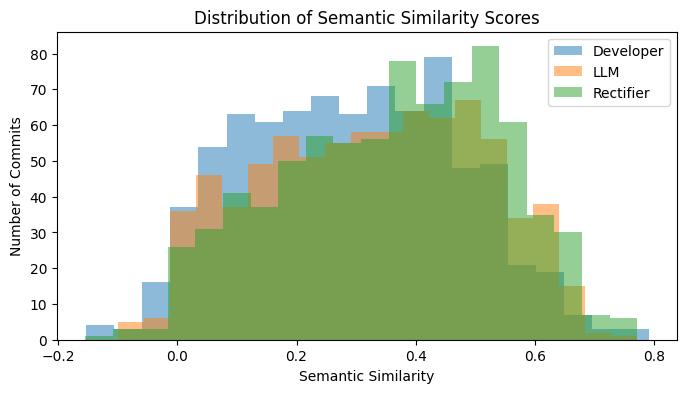

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df["Dev_semantic"], bins=20, alpha=0.5, label='Developer')
plt.hist(df["LLM_semantic"], bins=20, alpha=0.5, label='LLM')
plt.hist(df["Rect_semantic"], bins=20, alpha=0.5, label='Rectifier')
plt.xlabel("Semantic Similarity")
plt.ylabel("Number of Commits")
plt.title("Distribution of Semantic Similarity Scores")
plt.legend()
plt.show()


=== Semantic Evaluation Table ===
        Evaluation  Semantic_HitRate
0  Developer (RQ1)          0.309912
1        LLM (RQ2)          0.390213
2  Rectifier (RQ3)          0.456713


/tmp/ipython-input-2103953005.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Evaluation", y="Semantic_HitRate", data=semantic_table, palette="Greens_d")


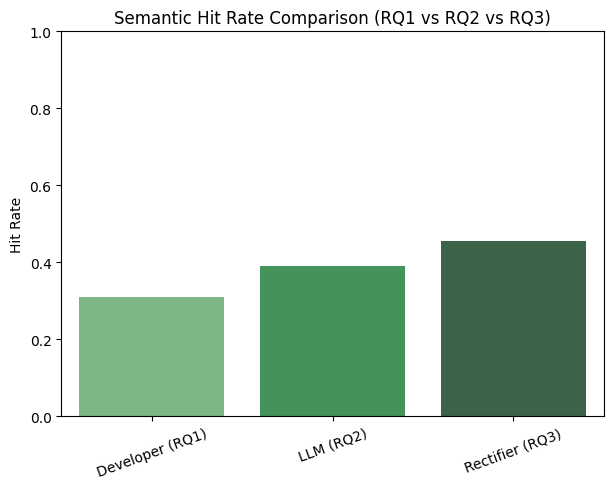

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare semantic results
semantic_table = pd.DataFrame({
    "Evaluation": ["Developer (RQ1)", "LLM (RQ2)", "Rectifier (RQ3)"],
    "Semantic_HitRate": [
        results_semantic["RQ1_Developer_SemHit"],
        results_semantic["RQ2_LLM_SemHit"],
        results_semantic["RQ3_Rectifier_SemHit"]
    ]
})

print("\n=== Semantic Evaluation Table ===")
print(semantic_table)

# Bar plot
plt.figure(figsize=(7,5))
sns.barplot(x="Evaluation", y="Semantic_HitRate", data=semantic_table, palette="Greens_d")

plt.title("Semantic Hit Rate Comparison (RQ1 vs RQ2 vs RQ3)")
plt.ylabel("Hit Rate")
plt.ylim(0,1)  # normalize scale 0–1
plt.xlabel("")
plt.xticks(rotation=20)
plt.show()